# **人臉識別分類器：Yale Face 資料集的性能評比研究**


---


## 專案前言：

在當今數位時代，人臉識別技術在各個領域都有著廣泛的應用，從安全系統到社交媒體，都需要高效且準確的人臉識別分類器。為了不斷提升這些分類器的性能，我們進行了一項針對Yale Face資料集的性能評比研究。這個研究的目標是比較不同的分類器，包括多元羅吉斯回歸、支援向量機和神經網路，並評估它們在人臉識別方面的表現。


## 專案目標簡介：

本專案的主要目標是探究並評估多種不同的人臉識別分類器在Yale Face資料集上的性能。我們將利用經過標準化的訓練資料，分別訓練多元羅吉斯回歸、支援向量機和神經網路等分類器，並使用獨立的測試資料集來評估它們的準確性和性能。

通過這項研究，我們的目標如下：

1. 比較不同分類器在人臉識別方面的效能，以確定哪種方法在Yale Face資料集上表現最佳。

2. 評估每個分類器的識別率和誤判率，以量化其性能。

3. 使用交叉驗證策略，全面優化各個分類器，以確保它們能夠適應不同的情境。

4. 分析分類器的優勢和限制，提供改進建議，以便未來的應用中能夠更好地應對人臉識別挑戰。

這些目標不僅有助於我深入瞭解不同人臉識別方法的適用性，還提供了寶貴的學習機會，讓我更好地應對未來的數據科學和機器學習挑戰。


---







## **匯入套件**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## **檔案讀入以及資料前處理**

In [ ]:
# 讀取數據
data = scipy.io.loadmat('/content/drive/MyDrive/淺度機器學習/allFaces.mat')
X = data['faces'].T

# 構建標籤
label_counts = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63, 63,
                64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
                64, 64, 64, 64]
labels = np.repeat(np.arange(len(label_counts)), label_counts)

# 將標籤添加到X數組中
X_labeled = np.c_[X, labels]

# 將X_labeled轉換為dataframe
df = pd.DataFrame(X_labeled, columns=[f"{i}" for i in range(X.shape[1])] + ["label"])


以上程式碼讀取了一個.mat格式的Yale Face 人臉資料集，然後從數據中構建了標籤(label)。接著，它使用numpy的repeat函數重複每個標籤的值，將標籤添加到影像資料數組中，並將整個結果轉換為一個Pandas DataFrame。最終得到的DataFrame包含了影像資料和對應的標籤。

In [ ]:
df['label'].nunique()

38

經過 `df['label'].nunique()` 的計算，可以確定 Yale Face 人臉資料集中包含 38 個不同的人臉圖像。

In [ ]:
df.shape

(2410, 32257)

根據 df.shape 的結果，Yale Face  人臉資料集的 DataFrame 共有 2410列和 , 32257 行，其中最後一行是用於表示圖像所屬人的唯一 ID。如果扣除這一列標籤欄，DataFrame 將具有 2410列和  32257 行，表示這個資料集中包含了2410 張人臉圖像。每個人都提供了 60 張不同的人臉圖像，總共有 38 個不同的人。每張人臉圖像都被表示為一個一維陣列，長度為 32256 。這些一維陣列可以被重塑為 168x192 的矩陣，以便對圖像進行可視化或進一步的處理。

## **人臉圖像展示(修改自[Eigenfaces](https://github.com/daradecic/Python-Eigenfaces/blob/master/EigenFaces.ipynb))**

In [ ]:
def plot_random_faces(pixels, n=50):
    fig, axes = plt.subplots(5, 10, figsize=(14, 6))
    sample_indices = random.sample(range(len(pixels)), n)
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[sample_indices[i]].reshape(168, 192).T, cmap='gray')
        ax.axis('off')
    plt.show()


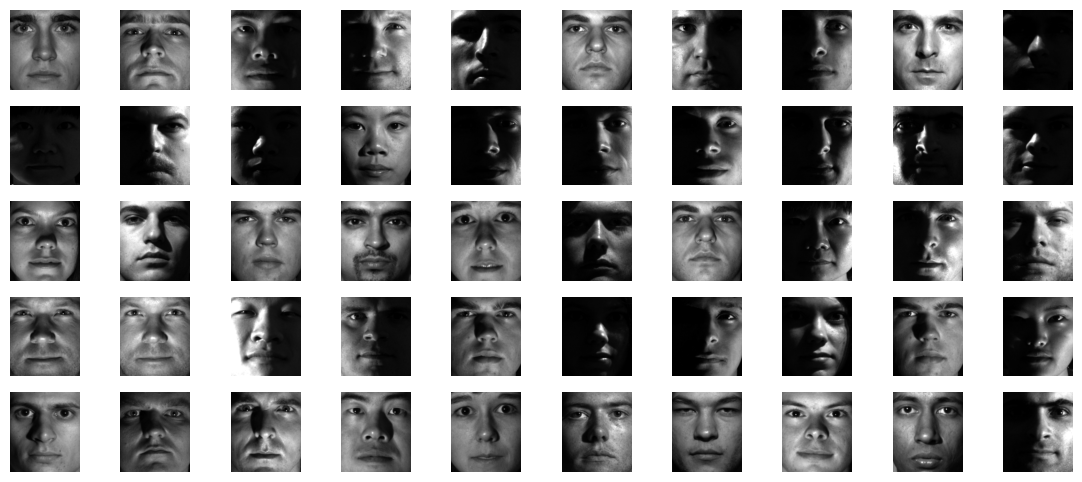

In [ ]:
X = df.drop('label', axis=1)
y = df['label']
plot_random_faces(X)

以上程式碼展示了隨機挑選的 50 張人臉影像，透過這些影像，可以觀察到在不同的光影角度下，人臉的外貌會有所不同。例如，在某些影像中，臉部的輪廓清晰可見，而在其他影像中，臉部的細節可能因光線的變化而產生明暗不一的區域。此外，還可以觀察到人臉在不同的角度下，眼睛、嘴巴和鼻子等特徵的位置和大小也會有所變化，這些特徵的變化可能會影響人臉的識別和辨識。

## **資料切割及資料標準化**

In [ ]:
#預處理
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

#切割資料
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=7)

#資料標準化
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## **利用主成分分析取得前兩項成分，並繪製其散布圖。**

In [ ]:
# 創建PCA對象，進行標準化
pca_normalized = PCA()
scaler = StandardScaler()

# 對數據進行標準化和擬合
data_standardized = scaler.fit_transform(df)
pca_normalized.fit(data_standardized)
transformed_normalized = pca_normalized.transform(data_standardized)
labels = df['label']


<ipython-input-22-21c170b1f470>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pc1[mask], pc2[mask], c=color, label=label)


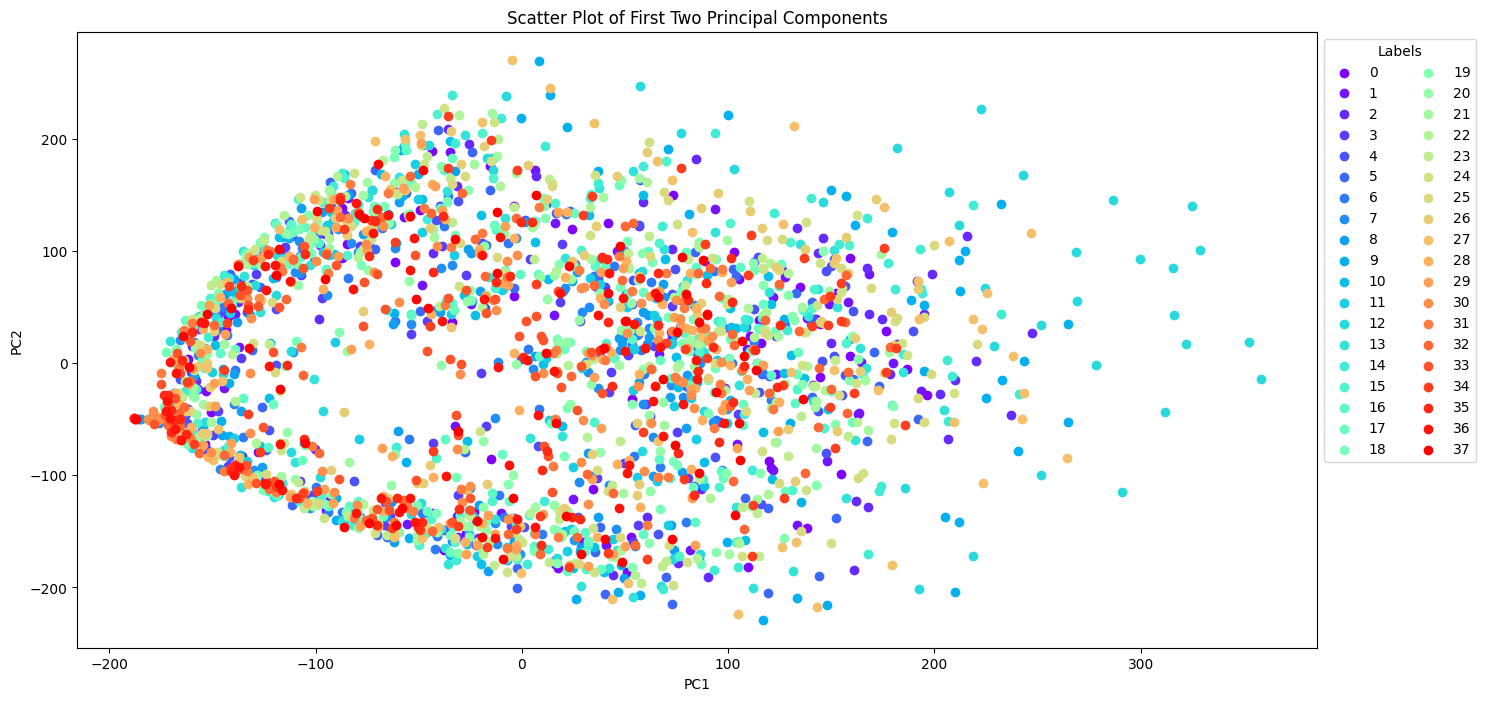

In [ ]:
n_labels = 38
colors = plt.cm.rainbow(np.linspace(0, 1, n_labels))

pc1 = transformed_normalized[:, 0]
pc2 = transformed_normalized[:, 1]

plt.figure(figsize=(16, 8))
for label, color in zip(range(n_labels), colors):
    mask = (labels == label)
    plt.scatter(pc1[mask], pc2[mask], c=color, label=label)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of First Two Principal Components')
plt.legend(title="Labels", ncol=2, bbox_to_anchor=(1, 1.0))
plt.show()

通過觀察前兩個主成分的散佈圖，我們可以發現資料點非常分散，並且很難辨認出任何明顯的分類規律。這表示前兩個主成分無法很好地解釋資料中的變異性，因此我們需要考慮探索更多的主成分，以便更全面地捕捉資料的變異性。

根據以上資訊，我們的資料屬於高維度，因此在進行機器學習分類時，建議先挑選適合高維度的超參數和算法進行設定和實現。


## **第一段 : 使用經過標準化的訓練資料來訓練多元羅吉斯回歸(Multinomial Logistic Regression)、支援向量機(Support Vector Machine)、神經網路模型(Neural Network)，並使用測試資料集來評估模型的準確性。**


---



## **1-1 多元羅吉斯回歸 (Multinomial Logistic Regression)**

在此多元羅吉斯回歸模型中，設定了 `solver='lbfgs'` 參數，這代表我們指定使用 lbfgs
演算法。"lbfgs" 算法適用於高維度的問題，且通常比 "liblinear" 算法更快。由於 "lbfgs" 算法是基於梯度下降的優化算法，因此可以更有效地處理具有大量特徵的數據集。

In [ ]:
opts = dict(tol = 1e-6, max_iter = int(1e3))
#opts = {'tol': 1e-6, 'max_iter': int(1e6), 'verbose': 1}

solver = 'lbfgs'

mlr_clf_original = LogisticRegression(solver = solver, **opts)
mlr_clf_original.fit(X_train_, y_train)
y_pred = mlr_clf_original.predict(X_test_)

# 測試資料之準確率回報
print(f'Test set classification accuracy of Multinomial Logistic Regression:
{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Multinomial Logistic Regression:
{mlr_clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test set classification accuracy of Multinomial Logistic Regression: 96.40%

Test set classification accuracy of Multinomial Logistic Regression: 96.40%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.88      1.00      0.94        15
           2       1.00      0.81      0.89        21
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        24
           6       1.00      0.91      0.95        23
           7       0.94      0.80      0.86        20
           8       0.86      1.00      0.92        18
           9       1.00      0.94      0.97        17
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        13
          13 

根據結果顯示，Multinomial Logistic Regression在這個測試集上達到了96.4%的分類準確率。從分類報告可以看出，對於大多數類別，分類器都能達到很好的精確度、召回率和F1得分。

這個分類器的正確率很高，但是執行一次需要**十分鐘**，這意味著在需要即時結果的應用中，它可能不太實用。為了改進這個問題，可以考慮使用主成分分析(PCA)來降低特徵維度，以提高分類器的運行效率。

## **1-2 支援向量機 (Support Vector Machine)**

在這個 SVM 分類器中，我們選擇了 `kernel='rbf'`，這代表我們使用 RBF 核函數進行分類。RBF 核函數是 SVM 中最常用的核函數之一，可以有效地處理非線性可分數據。同時，我們設定了 C = 10 的懲罰參數，這是 SVM 的正則化參數，控制著模型對於錯誤的容忍度。

In [ ]:
C = 10
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))

svm_clf_original = SVC(kernel = 'rbf', **opts)
svm_clf_original.fit(X_train_, y_train)
y_pred = svm_clf_original.predict(X_test_)
print(f'Test set classification accuracy of Support Vector Machin:
{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Support Vector Machin:
{svm_clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Support Vector Machin: 93.36%

Test set classification accuracy of Support Vector Machin: 93.36%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.93      0.97        15
           2       1.00      0.81      0.89        21
           3       1.00      0.95      0.97        20
           4       0.82      1.00      0.90        14
           5       0.91      0.88      0.89        24
           6       1.00      0.87      0.93        23
           7       1.00      0.85      0.92        20
           8       1.00      0.94      0.97        18
           9       0.74      0.82      0.78        17
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       0.93      1.00      0.96        13
          13       1.00      1.00

根據以上報告，Support Vector Machine模型在測試集上的分類準確率為93.36%。除類別9和類別35，大多數類別的F1分數都在0.9以上，顯示模型對大多數類別的預測都是準確的。總體而言，這個結果顯示了SVM模型在這個分類任務上的相對良好表現。

## **1-3 神經網路 (Neural Network)**

在這個神經網絡分類器中，我們選擇了一個隱藏層，其中包含 50 個神經元。我們選擇使用 ReLU 激活函數來增強模型的非線性能力，同時使用 lbfgs 求解器來優化模型參數。

In [ ]:
hidden_layers = (50, )
activation = 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False,
             activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning # solver = ’lbfgs’ # not suitable here
solver = 'lbfgs' # default solver
Ann_clf_original = MLPClassifier(solver = solver, random_state = 8
, **opts)
Ann_clf_original.fit(X_train_, y_train)
y_pred= Ann_clf_original.predict(X_test_)

print(f'Test set classification accuracy of Neural Network:
{accuracy_score(y_test, y_pred):.2%}\n')
print(f'Test set classification accuracy of Neural Network:
{Ann_clf_original.score(X_test_, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Neural Network: 88.11%

Test set classification accuracy of Neural Network: 88.11%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.67      0.80      0.73        15
           2       0.89      0.81      0.85        21
           3       1.00      0.85      0.92        20
           4       1.00      1.00      1.00        14
           5       0.78      0.75      0.77        24
           6       0.94      0.74      0.83        23
           7       1.00      0.75      0.86        20
           8       1.00      0.94      0.97        18
           9       0.62      0.88      0.73        17
          10       0.96      1.00      0.98        23
          11       0.88      0.92      0.90        24
          12       0.81      1.00      0.90        13
          13       1.00      0.78      0.88    

使用神經網絡進行測試，分類準確率達到了88.11%。然而，一些類別的精確度和召回率相對較低，這可能需要進一步調整模型以提高整體表現。儘管已經達到了不錯的結果，但仍有很大的優化空間，因為神經網路模型有很多參數可以進行優化。因此，可以通過調整參數或使用其他更高級的技術來優化模型以提高分類準確率。

## **第二段 : 利用經過標準化的原始資料的主成分來訓練模型，並使用測試資料來評估模型的準確度**


---



## **將 Yale Face 人臉資料集資料進行 PCA 降維，並保留前50個主成分。**

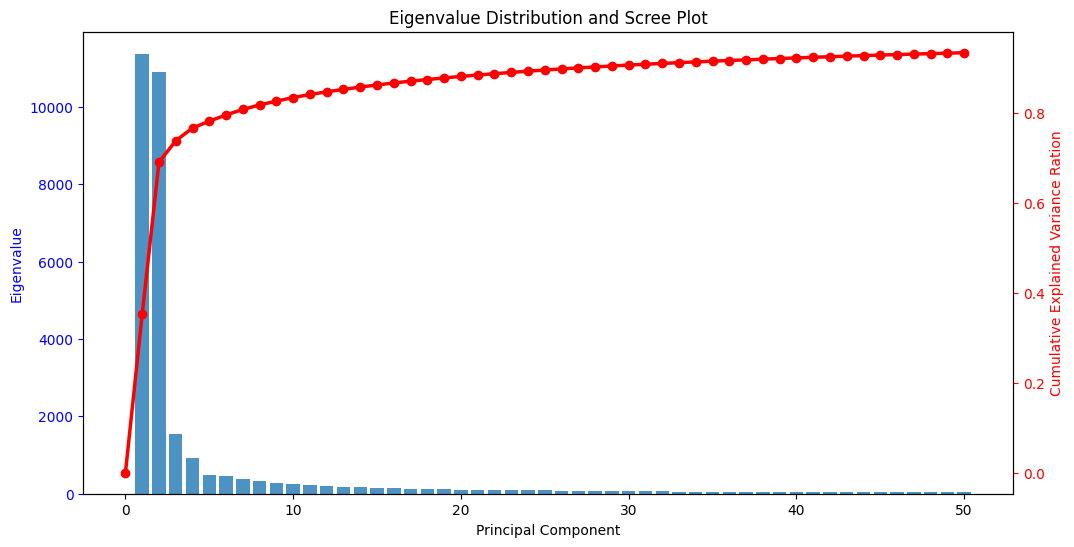

主成份分析的累積解釋變異：

[0.35254127 0.69079556 0.73856932 0.76697139 0.78202694 0.79603751
 0.80816716 0.81833265 0.82663486 0.8346434  0.84145958 0.84741833
 0.85283535 0.85798377 0.86271954 0.86712636 0.87112087 0.87478369
 0.87837713 0.88163796 0.88474655 0.88770781 0.89057342 0.89336401
 0.89594828 0.89837475 0.90062216 0.90280353 0.90490024 0.90691285
 0.90878072 0.91058365 0.91233318 0.91398371 0.91555888 0.91709144
 0.91859833 0.92009587 0.92149494 0.92287679 0.92420583 0.92550256
 0.92675147 0.92795801 0.92914919 0.93032446 0.93137862 0.93241445
 0.9334238  0.93440467]


In [ ]:
from sklearn.decomposition import PCA
pca_normalized = PCA(n_components = 50).fit(X_train_)

# 計算特徵值和特徵向量
eigenvalues = pca_normalized.explained_variance_
eigenvectors = pca_normalized.components_

# 繪製特徵值分佈圖和scree plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# 繪製特徵值條形圖
ax1.bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Eigenvalue Distribution and Scree Plot')

# 繪製累積解釋方差曲線
ax2 = ax1.twinx()
ax2.plot(np.insert(np.cumsum(pca_normalized.explained_variance_ratio_),
                   0, 0), 'ro-', linewidth=2.5)
ax2.set_ylabel('Cumulative Explained Variance Ration', color='r')
ax2.tick_params('y', colors='r')
plt.show()
print('主成份分析的累積解釋變異：\n')
print(np.cumsum(pca_normalized.explained_variance_ratio_))

In [ ]:
pca_normalized = PCA(n_components = 50).fit(X_train_)
Z_train = pca_normalized.transform(X_train_)
Z_test = pca_normalized.transform(X_test_)

根據主成份分析的累積解釋變異累積報表，我們可以觀察到，保留前50個主成份時，能夠解釋資料變異的比例大約為93.44%。即使無法解釋所有的變異，使用主成份分析仍然是一種簡單有效的資料降維方法，可以在保留少量資訊的情況下進行資料分析、分類和預測。使用PCA降維後，原本的資料維度從32256維降至50維，即僅保留50個主成分。這樣做的好處是大幅減少了資料的維度，從而降低計算量和記憶體需求。這也意味著，原本的資料維度被壓縮了約645倍，這是相當顯著的成果。

以下將進行三種分類器的實作。


## **2-1 主成分分析在多元羅吉斯回歸中的應用 (Multinomial Logistic Regression with PCA)**

此多元羅吉斯回歸模型所設定的參數與第一段相同。

In [ ]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
solver = 'lbfgs'
mlr_clf_PCA = LogisticRegression(solver = solver, **opts)
mlr_clf_PCA.fit(Z_train, y_train)
y_pred = mlr_clf_PCA.predict(Z_test)
print(f'Test set classification accuracy of Multinomial Logistic Regression with PCA:
{mlr_clf_PCA.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Multinomial Logistic Regression with PCA: 92.67%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.78      0.93      0.85        15
           2       1.00      0.76      0.86        21
           3       0.95      0.95      0.95        20
           4       1.00      1.00      1.00        14
           5       0.95      0.75      0.84        24
           6       0.95      0.87      0.91        23
           7       1.00      0.80      0.89        20
           8       0.90      1.00      0.95        18
           9       1.00      0.94      0.97        17
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       0.93      1.00      0.96        13
          13       1.00      0.94      0.97        18
          14       0.75    

根據以上報表顯示，使用前50個主成份的多元羅吉斯回歸模型在120個測試樣本上的分類準確率達92.67%。


---



相較於未降維的**(1-1多元羅吉斯回歸)**模型，使用PCA進行降維後的模型準確率確實有所下降，但是這個下降的幅度不是很嚴重。原來的模型準確率為96.40%，而使用PCA進行降維後的模型準確率降至92.67%。這意味著，使用PCA進行降維後的模型仍然可以在相當高的準確率下進行分類。

## **2-2 主成分分析在支援向量機的應用 (Support Vector Machine with PCA)**

此支援向量機模型所設定的參數與第一段相同。

In [ ]:
C = 10
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))

svm_clf_PCA = SVC(kernel = 'rbf', **opts)
svm_clf_PCA.fit(Z_train, y_train)
y_pred = svm_clf_PCA.predict(Z_test)
print(f'Test set classification accuracy of Support Vector Machin with PCA:
{svm_clf_PCA.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Support Vector Machin with PCA: 88.80%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.88      0.93      0.90        15
           2       1.00      0.76      0.86        21
           3       1.00      0.95      0.97        20
           4       0.64      1.00      0.78        14
           5       0.91      0.83      0.87        24
           6       1.00      0.87      0.93        23
           7       0.93      0.70      0.80        20
           8       1.00      0.94      0.97        18
           9       0.78      0.82      0.80        17
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        13
          13       1.00      0.89      0.94        18
          14       0.71      0.83    

根據以上報表顯示，使用前50個主成份的支援向量機模型在723個測試樣本上的分類準確率達89.07%。

---



相較於未降維的**(1-2支援向量機)**，經過PCA進行降維後，模型在測試集的準確率由93.36%降至89.07%。這表明，使用PCA進行降維可能會導致某些關鍵特徵的丟失，進而影響模型的性能。但仍然是一個不錯的結果。


## **2-3 主成分分析在神經網路的應用 (Neural Network with PCA)**

此神經網路模型所設定的參數與第一段相同。

In [ ]:
hidden_layers = (50, )
activation = 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False,
             activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'lbfgs'
Ann_clf_PCA = MLPClassifier(solver = solver, random_state = 8
, **opts)
Ann_clf_PCA.fit(Z_train, y_train)
y_pred= Ann_clf_PCA.predict(Z_test)

print(f'Test set classification accuracy of Neural Network:
{Ann_clf_PCA.score(Z_test, y_test):.2%}\n')
print('---------------------------------------------------------------------------')
print(classification_report(y_test, y_pred))

Test set classification accuracy of Neural Network: 85.89%

---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.76      0.87      0.81        15
           2       0.67      0.67      0.67        21
           3       1.00      0.90      0.95        20
           4       0.76      0.93      0.84        14
           5       0.91      0.83      0.87        24
           6       0.83      0.83      0.83        23
           7       0.79      0.75      0.77        20
           8       1.00      0.94      0.97        18
           9       0.83      0.88      0.86        17
          10       0.87      0.87      0.87        23
          11       0.90      0.79      0.84        24
          12       0.92      0.92      0.92        13
          13       0.94      0.83      0.88        18
          14       0.71      0.83      0.77        12

根據以上報表顯示，使用前50個主成份的神經網路模型在723個測試樣本上的分類準確率達84.51%。


---



相較於未降維的**(1-3神經網路)**，經過PCA進行降維後，使用神經網路進行分類的模型在測試集上的準確率從88.11%下降至84.51%。但仍然是一個具有應用價值的模型。需要進一步分析和調整模型的參數，以提高其準確率。

---



## **第三段 : 使用交叉驗證進行分類器的全面優化策略**

在機器學習的模型訓練中，為了避免過擬合和選擇最佳的超參數，交叉驗證已經成為一種常用的技術。在本段落中，我們將使用5-fold交叉驗證來對每種分類器進行全面優化，以確定最佳的超參數設置。我們將使用Scikit-learn套件中的GridSearchCV函數對模型的超參數進行調整，以獲得最優的模型。

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# 1. 定義 Pipeline
pipe_lr = Pipeline([('lr', LogisticRegression())])
pipe_svm = Pipeline([('svm', SVC())])
pipe_ann = Pipeline([('ann', MLPClassifier())])
pipe_lr_pca = Pipeline([('pca', PCA()), ('lr', LogisticRegression())])
pipe_svm_pca = Pipeline([('pca', PCA()), ('svm', SVC())])
pipe_ann_pca = Pipeline([('pca', PCA()), ('ann', MLPClassifier())])

# 2. 定義參數範圍
params_lr = {'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

params_svm = {'svm__C': [0.1, 1, 10, 100],
              'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

params_ann = {'ann__hidden_layer_sizes':
 [(30,), (50,), (100,), (30, 30), (50, 30)],
              'ann__activation': ['identity', 'logistic', 'tanh', 'relu'],
              'ann__solver': ['lbfgs', 'sgd', 'adam']}

params_lr_pca = {'pca__n_components': [50], 'lr__solver':
 ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

params_svm_pca = {'pca__n_components': [50], 'svm__C':
 [0.1, 1, 10, 100], 'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

params_ann_pca = {'pca__n_components': [50], 'ann__hidden_layer_sizes':
 [(30,), (50,), (100,), (30, 30), (50, 30)], 'ann__activation':
  ['identity', 'logistic', 'tanh', 'relu'], 'ann__solver': ['lbfgs', 'sgd', 'adam']}

# 3. 定義 GridSearchCV
grid_lr_pca = GridSearchCV(pipe_lr_pca, params_lr_pca, cv=5)
grid_svm_pca = GridSearchCV(pipe_svm_pca, params_svm_pca, cv=5)
grid_ann_pca = GridSearchCV(pipe_ann_pca, params_ann_pca, cv=5)

# 4. 進行交叉驗證調整參數並找到最好的模型
grid_lr_pca.fit(X_train_, y_train)
grid_svm_pca.fit(X_train_, y_train)
grid_ann_pca.fit(X_train_, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('ann', MLPClassifier())]),
             param_grid={'ann__activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                         'ann__hidden_layer_sizes': [(30,), (50,), (100,),
                                                     (30, 30), (50, 30)],
                         'ann__solver': ['lbfgs', 'sgd', 'adam'],
                         'pca__n_components': [50]})

因為在原始數據上訓練的模型需要處理大量的特徵，所以在沒有PCA降維處理的情況下，模型需要處理大量的計算，因此模型的訓練時間會非常長。因此，在本次實驗中，我們只對PCA後的資料進行了交叉驗證。

In [ ]:
# 5. 計算最好的參數和交叉驗證得分
print('PCA + Logistic Regression:', grid_lr_pca.best_params_, grid_lr_pca.best_score_)
print('PCA + SVM:', grid_svm_pca.best_params_, grid_svm_pca.best_score_)
print('PCA + Neural Network:', grid_ann_pca.best_params_, grid_ann_pca.best_score_)

PCA + Logistic Regression: {'lr__solver': 'newton-cg', 'pca__n_components': 50} 0.9098958790581708
PCA + SVM: {'pca__n_components': 50, 'svm__C': 0.1, 'svm__kernel': 'linear'} 0.8903306234965672
PCA + Neural Network: {'ann__activation': 'logistic', 'ann__hidden_layer_sizes': (100,), 'ann__solver': 'adam', 'pca__n_components': 50} 0.9330149421452777


在此使用了三種不同的模型，並且在每種模型中使用了PCA降維，得到了對應的訓練正確率。其中，PCA + Neural Network模型的訓練正確率最高，達到了0.933，也就是在訓練集上，模型對於分類結果的準確率較高。而其他兩種模型，其訓練正確率分別為0.910和0.890，相對較低。

In [ ]:
y_pred_lr_pca = grid_lr_pca.predict(X_test_)
accuracy_lr_pca = accuracy_score(y_test, y_pred_lr_pca)
print(f'Test set classification accuracy of Logistic Regression with PCA:
{accuracy_lr_pca:.2%}\n')

y_pred_svm_pca = grid_svm_pca.predict(X_test_)
accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
print(f'Test set classification accuracy of SVM with PCA:
{accuracy_svm_pca:.2%}\n')

y_pred_ann_pca = grid_ann_pca.predict(X_test_)
accuracy_ann_pca = accuracy_score(y_test, y_pred_ann_pca)
print(f'Test set classification accuracy of Neural Network with PCA:
{accuracy_ann_pca:.2%}\n')


Test set classification accuracy of Logistic Regression with PCA: 92.81%

Test set classification accuracy of SVM with PCA: 91.42%

Test set classification accuracy of Neural Network with PCA: 93.64%



從三種方法的測試正確率來看，神經網路的表現最佳，其次是羅吉斯回歸，SVM 的表現最差。這可能是因為神經網路具有更高的彈性，可以學習更複雜的非線性決策邊界，因此在應對複雜的數據集時表現更好。

此外，PCA降維處理在本例中是相當重要的，因為可以大幅提高模型訓練速度並兼具模型的性能。

---



## **結語：**

在本次人臉識別分類器的性能評比研究中，我們得出了一些重要的結論。根據測試正確率的結果，我們可以明確看出，神經網路在這項任務中表現最佳，其次是羅吉斯回歸，而SVM則表現最差。這一結果可能是由於神經網路具有更高的彈性，能夠學習更複雜的非線性決策邊界，因此在處理複雜的數據集時更具優勢。

此外，我們也強調了PCA（主成分分析）降維處理在本例中的重要性。這個過程不僅大幅提高了模型的訓練速度，還兼具改善模型性能的功能。這個結論強調了在處理大型數據集時，降維技術可以有效地提高計算效率，同時確保模型的性能不會受到過多的維度影響。

總之，這項研究為我們提供了對不同人臉識別方法的性能比較，並突顯了神經網路和PCA降維的重要性。這些結論將有助於未來的人臉識別系統設計和應用中，選擇適合的方法以提高準確性和效率。


---

